In [1]:
#Input path
data_path = "/Users/jorditorresvallverdu/Library/Mobile Documents/com~apple~CloudDocs/tse/year2/term2/io_empirique/RUST.DAT" ##-->CHANGE JUST THIS PART MANUALLY!

#Output path
export_dir = "/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/IO/" ##Change this manually too

"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/IO/"

In [2]:
using DataFrames, CSV

df = CSV.read(
    data_path,
    DataFrame;
    delim=' ',
    ignorerepeated=true,
    header=false
)

rename!(df, [:mileage, :change])

Row,mileage,change
,Int64,Int64
1,140953,2
2,142960,0
3,145380,0
4,148140,0
5,150921,0
6,153839,0
7,155841,0
8,158063,0
9,160674,0


In [3]:
#Data cleaning 

using ShiftedArrays


df.mileage = df.mileage ./ 10000

df.bus_id = cumsum(df.change .== 2)

df = transform(
    groupby(df, :bus_id),
    :mileage => (x -> ShiftedArrays.lag(x, 1)) => :lag_mileage
)





Row,mileage,change,bus_id,lag_mileage
,Float64,Int64,Int64,Float64?
1,14.0953,2,1,missing
2,14.296,0,1,14.0953
3,14.538,0,1,14.296
4,14.814,0,1,14.538
5,15.0921,0,1,14.814
6,15.3839,0,1,15.0921
7,15.5841,0,1,15.3839
8,15.8063,0,1,15.5841
9,16.0674,0,1,15.8063


---
**Problem 1**


---

In [4]:
using GLM, RegressionTables

probit_dta = filter(row -> row.change != 2, df)
probit_dta.change = ifelse.(probit_dta.change .== 1, 1, 0)

probit_dta = filter(row -> !ismissing(row.lag_mileage), probit_dta) #drop first row


m1 = glm(@formula(change ~ lag_mileage),
         probit_dta, Binomial(), ProbitLink())


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

change ~ 1 + lag_mileage

Coefficients:
────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       z  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  -3.32764   0.136366    -24.40    <1e-99  -3.59491    -3.06037
lag_mileage   0.062923  0.00688822    9.13    <1e-19   0.0494223   0.0764236
────────────────────────────────────────────────────────────────────────────

In [5]:
#Alternative specifications 
probit_dta.mileage2= probit_dta.lag_mileage.^2
probit_dta.mileage3= probit_dta.lag_mileage.^3
probit_dta.log_mileage = log.(1 .+ probit_dta.lag_mileage)

m2 = glm(@formula(change ~ lag_mileage + mileage2 ),
                   probit_dta,
                   Binomial(),
                   ProbitLink())


m3 = glm(@formula(change ~ lag_mileage + mileage2 + mileage3 ),
                   probit_dta,
                   Binomial(),
                   ProbitLink())

m4 = glm(@formula(change ~ log_mileage),
                   probit_dta,
                   Binomial(),
                   ProbitLink())




 regtable(
    m1, 
    m2,
    m3,
    m4;
    renderSettings = LatexTable(),
    file = joinpath(export_dir, "ps2_probit_op.tex")
)



┌ Warning: renderSettings is deprecated. Specify render type with render=LatexTable() and file with file=/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/IO/ps2_probit_op.tex
└ @ RegressionTables ~/.julia/packages/RegressionTables/wzLBu/src/regtable.jl:441


\begin{tabular}{lrrrr}
\toprule
             &           \multicolumn{4}{c}{change}          \\ 
\cmidrule(lr){2-5} 
             &       (1) &       (2) &       (3) &       (4) \\ 
\midrule
(Intercept)  & -3.328*** & -4.297*** & -6.652*** & -5.387*** \\ 
             &   (0.136) &   (0.419) &   (1.501) &   (0.429) \\ 
lag\_mileage &  0.063*** &  0.185*** &    0.608* &           \\ 
             &   (0.007) &   (0.046) &   (0.247) &           \\ 
mileage2     &           &  -0.003** &   -0.027* &           \\ 
             &           &   (0.001) &   (0.013) &           \\ 
mileage3     &           &           &     0.000 &           \\ 
             &           &           &   (0.000) &           \\ 
log\_mileage &           &           &           &  1.112*** \\ 
             &           &           &           &   (0.145) \\ 
\midrule
$N$          &     7,250 &     7,250 &     7,250 &     7,250 \\ 
Pseudo $R^2$ &     0.132 &     0.145 &     0.151 &     0.145 \\ 
\bottomrule
\end{tab

In [6]:
#comparing models ...

using StatsBase

models = Dict(
    "Linear"    => m1,
    "Quadratic" => m2,
    "Cubic"     => m3,
    "Log"       => m4
)

for (name, m) in models
    println(rpad(name, 10),
            "  AIC = ", round(aic(m), digits=2),
            "   BIC = ", round(bic(m), digits=2))
end

Quadratic   AIC = 632.31   BIC = 652.98
Cubic       AIC = 629.98   BIC = 657.54
Log         AIC = 630.83   BIC = 644.61
Linear      AIC = 640.29   BIC = 654.07


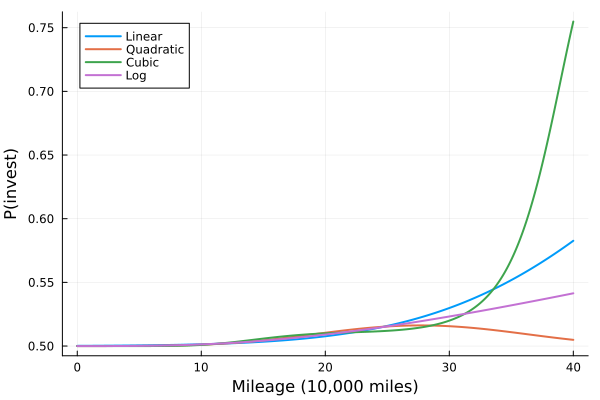

In [7]:
#plot

using DataFrames, Plots, GLM, Distributions

grid = collect(range(0, 40, length=400))

new_data = DataFrame(lag_mileage = grid)
new_data.mileage2    = new_data.lag_mileage .^ 2
new_data.mileage3    = new_data.lag_mileage .^ 3
new_data.log_mileage = log.(1 .+ new_data.lag_mileage)

η1 = predict(m1, new_data)
η2 = predict(m2, new_data)
η3 = predict(m3, new_data)
η4 = predict(m4, new_data)

p1 = cdf.(Normal(), η1)
p2 = cdf.(Normal(), η2)
p3 = cdf.(Normal(), η3)
p4 = cdf.(Normal(), η4)


plot(grid, p1, label="Linear", xlabel="Mileage (10,000 miles)", ylabel="P(invest)", linewidth=2)
plot!(grid, p2, label="Quadratic", linewidth=2)
plot!(grid, p3, label="Cubic", linewidth=2)
plot!(grid, p4, label="Log", linewidth=2)


---

**Question 2**

---

In [8]:
#Question 2
using ShiftedArrays, Statistics

df = transform(
    groupby(df, :bus_id), 
    :mileage => (x->lag(x,1)) => :lag_mileage
)
df.dif= df.mileage .- df.lag_mileage


df_valid = df[(df.change .== 0) .& .!ismissing.(df.lag_mileage), :]

mean_s = mean(df_valid.dif)
std_s  = std(df_valid.dif)

#oending to change this shit. IDK why the greek letters dont come up.

ps1_io_table_ex2 = DataFrame(
    Parameter = ["mean", "variance"],

    Values = [
       mean_s,
        std_s,
    ]
)
show(stdout, MIME("text/latex"), ps1_io_table_ex2)

\begin{tabular}{r|cc}
	& Parameter & Values\\
	\hline
	& String & Float64\\
	\hline
	1 & mean & 0.190387 \\
	2 & variance & 0.113453 \\
\end{tabular}


14

---

**Question 3**

---

In [9]:
#Create functions
using Base.MathConstants, Random


alpha= coef(m4)[1]
beta= coef(m4)[2]

#policy function
function p(s)
    eta= alpha + beta * log(1+s)
    p = cdf.(Normal(), eta)
    return p
end 

#fixed parameters
const β= 0.99

const T=100
const K=10

const γ = eulergamma


#from q2 we have epsilon~N(rho, sigma^p)
const rho=mean_s
const sigma=std_s

# Set seed for replicability and staibility of results
Random.seed!(1234)

TaskLocalRNG()

In [10]:
function x(s0, invest::Bool)

    k_vec_1 = zeros(K)
    k_vec_2 = zeros(K)
    k_vec_3 = zeros(K)

    for k in 1:K

        if invest
            s = s0
        else
            s = s0 + rand(Normal(rho, sigma))
        end

        for τ in 1:T

            prob = p(s)
            u = rand()

            if u < prob
                Y = 1
                s_next = 0
                prob_realized = prob
            else
                Y = 0
                s_next = s + rand(Normal(rho, sigma))
                prob_realized = 1 - prob
            end

            prob_realized = clamp(prob_realized, 1e-12, 1-1e-12)

            k_vec_1[k] += β^τ * (-Y)
            k_vec_2[k] += β^τ * (-s*(1-Y))
            k_vec_3[k] += β^τ * (γ - log(prob_realized))

            s = s_next
        end
    end

    return mean(k_vec_1), mean(k_vec_2), mean(k_vec_3)
end

x (generic function with 1 method)

In [ ]:
#construct the six items 
df_q3 = filter(row -> !ismissing(row.lag_mileage) && row.change != 2, df)


#Replacement today
x1_0start, x2_0start, x3_0start = x(0, true)

df_q3.x1_i1 .= -1 + x1_0start
df_q3.x2_i1 .= x2_0start
df_q3.x3_i1 .= x3_0start


#No replacement today
df_q3.x1_i0 = zeros(nrow(df_q3))
df_q3.x2_i0 = zeros(nrow(df_q3))
df_q3.x3_i0 = zeros(nrow(df_q3))

for i in 1:nrow(df_q3)
    s_i= df_q3.lag_mileage[i]
    df_q3.x1_i0[i], df_q3.x2_i0[i], df_q3.x3_i0[i] = x(s_i, false)
end 



(37.025037725256, 39.031065074207646)

In [17]:
mean(df_q3.x2_i1), mean(df_q3.x2_i0)


(-462.95013232456347, -687.9305407099539)